# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [ ]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, MSForwardModelSolver
from matplotlib import pyplot as plt

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### Simulated Probe Configuration

In [2]:
probe_config = ProbeConfig(
    type= ProbeType.AIRY_DISK,
    wave_length = 0.635e-6,        # meters (0.635 μm). Visible light
    diameter = 5e-6,               # [m]
    focus = -5e-6,                 # focal length [m]
    #tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

print(f"Probe options:\n - {'\n - '.join(ProbeType.list())}")

Probe options:
 - constant
 - gaussian
 - sinusoidal
 - complex_exp
 - dirichlet_test
 - neumann_test
 - airy_disk
 - disk
 - blurred_disk


### Discretization Parameters and Spatial Limits

In [3]:
# Width Discretization (Pixels)
scan_points = 60
step_size_px = 10
pad_factor = 2.0  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = False

# Thickness Discretization (Pixels)
points_per_wavelength = 8 # Points per Wavelength for Parallel Wave Equation Solver
nz = 50 # Slices for Multi-Slice
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(x=(0.0, 150e-6), # Sample width
                        z=(0.0, 75e-6), # Sample thickness
                        units="meters")


In [4]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization, 
# object domain.
# Solver parameters are defined in the solver classes.
sim_config_ms = SimulationConfig(
    probe_config=probe_config,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    nz = 50,  # Override for number of z-slices
    spatial_limits=spatial_limits,

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_ms = create_simulation_space(sim_config_ms)
simulation_space_ms.summarize()
print("Padding/Overlap:", simulation_space_ms.nx - simulation_space_ms.min_nx)

# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space_ms)

2025-12-03 09:33:00,337 - INFO - === Scan Summary (Continuous) ===
2025-12-03 09:33:00,338 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-03 09:33:00,339 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-03 09:33:00,340 - INFO -   Sample Pixels:          1201
2025-12-03 09:33:00,342 - INFO -   Number of scan points:  60
2025-12-03 09:33:00,344 - INFO -   Steps in z:             50
2025-12-03 09:33:00,346 - INFO -   Probe diameter:         5.000e-06 m
2025-12-03 09:33:00,349 - INFO -   Probe Pixels:          40 px
2025-12-03 09:33:00,350 - INFO -   Max Overlap:            3.750e-06 m
2025-12-03 09:33:00,352 - INFO -   Percentage Overlap:     75.00%



Padding/Overlap: 601


2025-12-03 09:33:00,427 - INFO - Saving refractive index field to /home/dnz75396/thick_ptycho/notebooks/2D_examples/results/ptycho_object_n_true.npy


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': ' Phase'}>,
        <Axes: title={'center': ' Amplitude'}>], dtype=object))

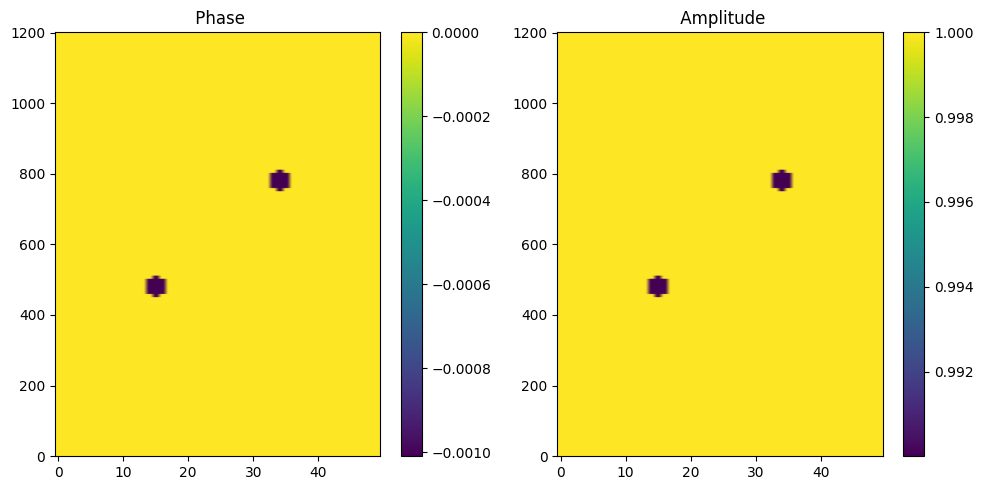

In [5]:
# --- Create a Simultated Ptycho Object ---
ptycho_object_ms = create_ptycho_object(simulation_space_ms)

# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index
delta = 0.01
beta = 0.001
refractive_index_perturbation = -delta - beta * 1j

# Add 6 spheres of varying positions
gaussian_blur = 0.0
common_side_length = 0.05 # Portion of x-length
common_depth = 0.05  # Portion of z-length
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length_factor=common_side_length,
                        centre_factor=(0.4, 0.3), depth_factor=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.add_object('circle', refractive_index_perturbation, side_length_factor=common_side_length,
                        centre_factor=(0.65, 0.7), depth_factor=common_depth, gaussian_blur=gaussian_blur)
ptycho_object_ms.build_field()

# --- Save and plot the true object ---
filepath = "/home/dnz75396/thick_ptycho/notebooks/2D_examples/results/ptycho_object_n_true.npy"
ptycho_object_ms.save_refractive_index(filepath)

# Plot the true object
simulation_space_ms.viewer.plot_two_panels(ptycho_object_ms.refractive_index,view="phase_amp")


2025-12-03 09:33:00,929 - INFO - === Scan Summary (Continuous) ===
2025-12-03 09:33:00,931 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-03 09:33:00,933 - INFO -   Sample space (z-range): 7.500e-05 m


2025-12-03 09:33:00,935 - INFO -   Sample Pixels:          1201
2025-12-03 09:33:00,937 - INFO -   Number of scan points:  60
2025-12-03 09:33:00,938 - INFO -   Steps in z:             944
2025-12-03 09:33:00,939 - INFO -   Probe diameter:         5.000e-06 m
2025-12-03 09:33:00,943 - INFO -   Probe Pixels:          40 px
2025-12-03 09:33:00,943 - INFO -   Max Overlap:            3.750e-06 m
2025-12-03 09:33:00,944 - INFO -   Percentage Overlap:     75.00%



Original refractive index shape: (1201, 944)
Loaded refractive index shape: (1201, 50)
Loaded refractive index new shape: (1201, 944)


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': ' Phase'}>,
        <Axes: title={'center': ' Amplitude'}>], dtype=object))

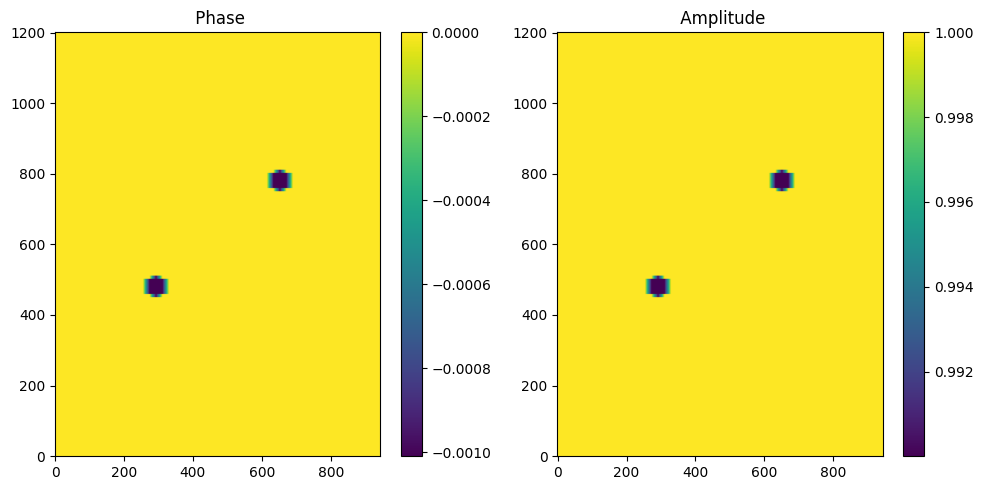

In [6]:
# --- Create the SimulationConfig object ---
sim_config_pwe = SimulationConfig(
    probe_config=probe_config,

    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,

    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0, # 1.0 for free space

    # Logging and results
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space_pwe = create_simulation_space(sim_config_pwe)
simulation_space_pwe.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object_pwe = create_ptycho_object(simulation_space_pwe)
ptycho_object_pwe.load_and_resize_refractive_index(filepath)
simulation_space_pwe.viewer.plot_two_panels(ptycho_object_pwe.refractive_index,view="phase_amp")


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [7]:
# Solve Full Space Space, Iterative

# --- Create Forward Model ---
forward_model_pwe = PWEIterativeLUSolver(simulation_space_pwe, ptycho_probes)

# Iterative solution
u_pwe = forward_model_pwe.solve(n=ptycho_object_pwe.refractive_index)
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
u_pwe = u_pwe[0,0,...]

/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


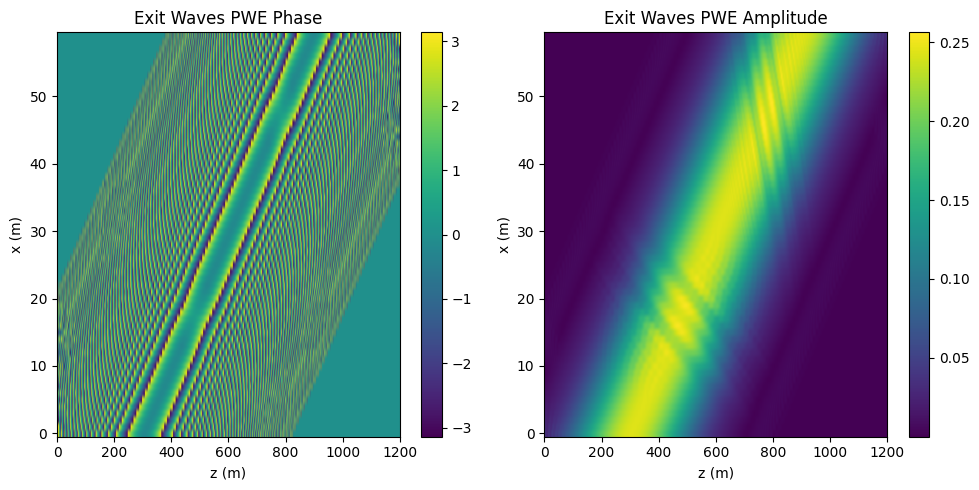

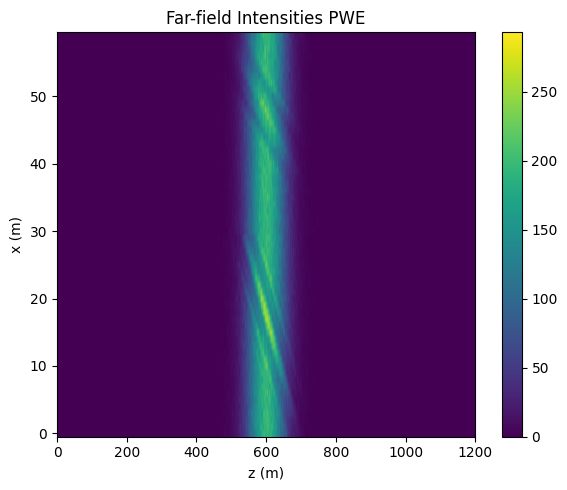

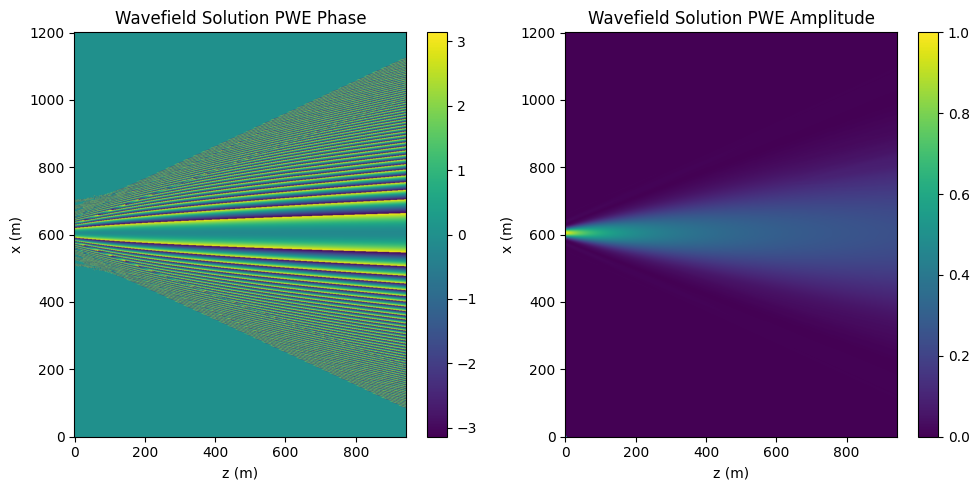

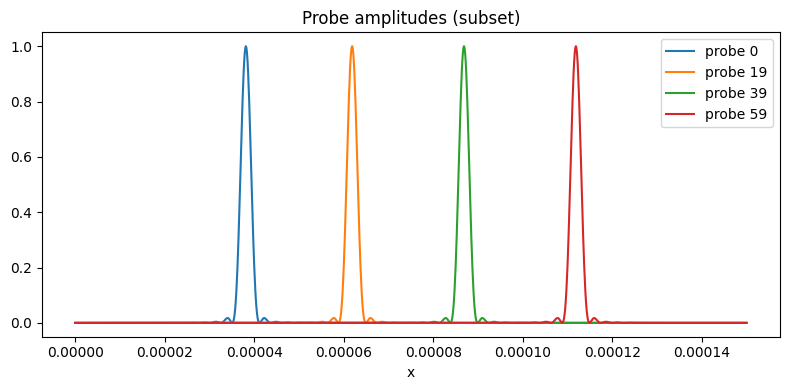

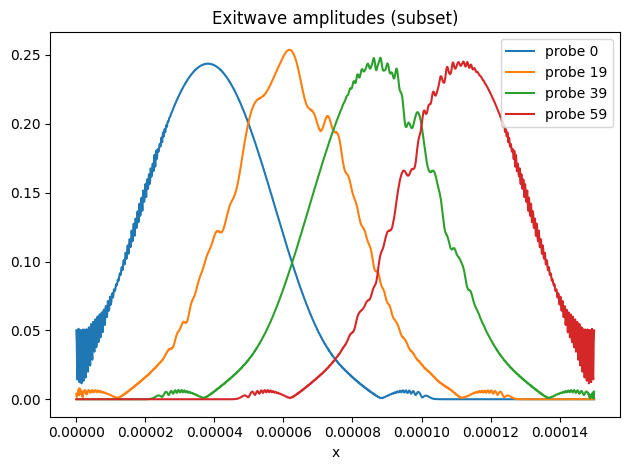

In [8]:
simulation_space_pwe.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space_pwe.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe),
                                        title="Far-field Intensities PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_pwe = u_pwe[simulation_space_pwe.num_probes//2, ...]
simulation_space_pwe.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space_pwe.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
probe_indices = np.linspace(0, simulation_space_pwe.num_probes-1, min(4, simulation_space_pwe.num_probes), dtype=int)
for p in probe_indices:
    plt.plot(simulation_space_pwe.x, np.abs(u_pwe[p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space_pwe.x, np.abs(u_pwe[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()


In [9]:
# Solve Full Space Space, Multislice

forward_model_ms = MSForwardModelSolver(simulation_space_ms,
                                ptycho_probes)

# Iterative solution
u_ms = forward_model_ms.solve(n=ptycho_object_ms.refractive_index)[0,0,...]
exit_waves_ms =forward_model_ms.get_exit_waves(u_ms)
intensities_ms = forward_model_ms.get_farfield_intensities(exit_waves=exit_waves_ms, 
                                                               poisson_noise=True)

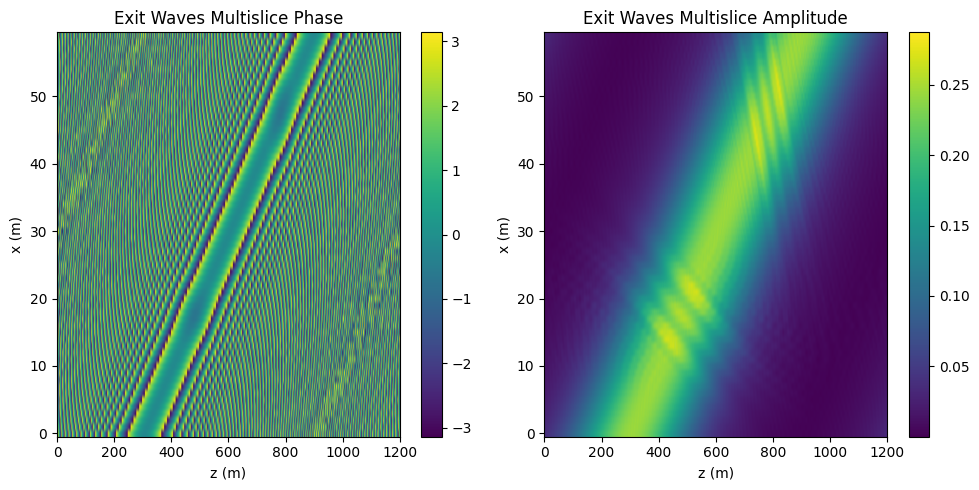

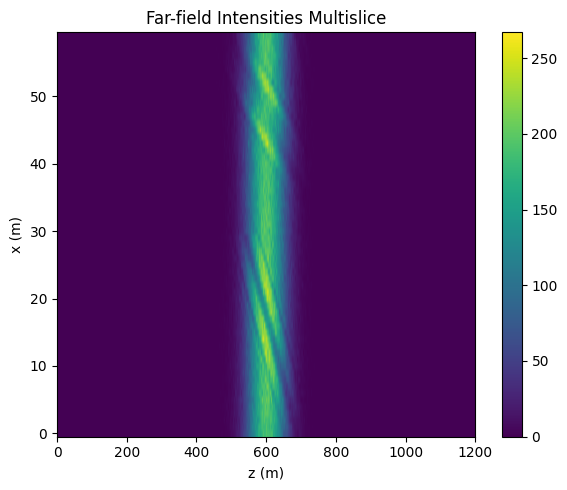

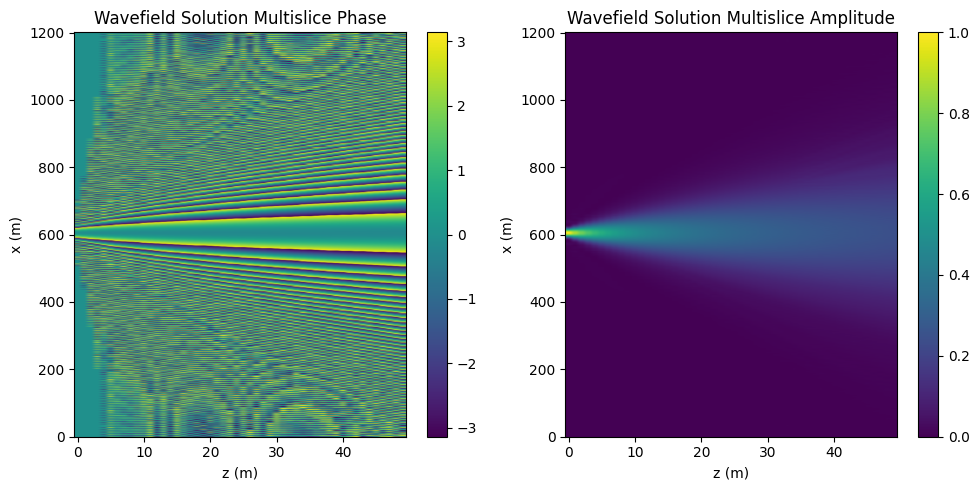

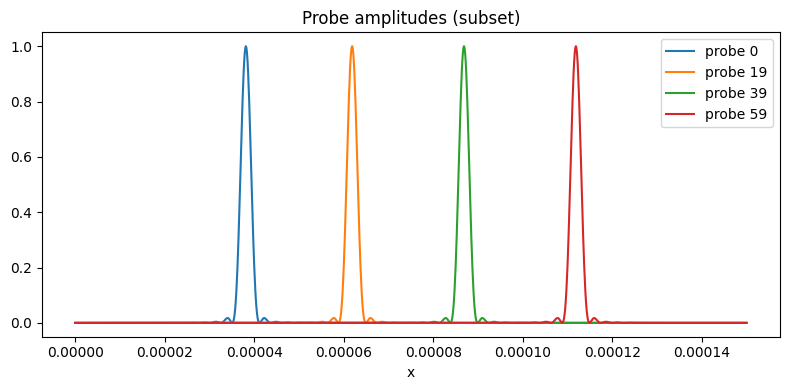

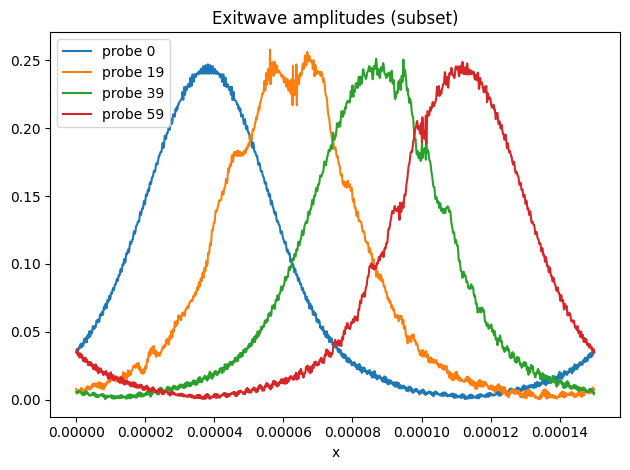

In [10]:
simulation_space_ms.viewer.plot_two_panels(exit_waves_ms,
                                        view="phase_amp", 
                                        title="Exit Waves Multislice",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

simulation_space_ms.viewer.plot_single_panel(np.fft.fftshift(intensities_ms),
                                        title="Far-field Intensities Multislice",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

# Select Centre Probe
centre_probe_ms = u_ms[simulation_space_ms.num_probes//2, ...]
simulation_space_ms.viewer.plot_two_panels(centre_probe_ms,
                                        view="phase_amp", 
                                        title="Wavefield Solution Multislice",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.figure(figsize=(8,4))
probe_indices = np.linspace(0, simulation_space_pwe.num_probes-1, min(4, simulation_space_pwe.num_probes), dtype=int)
for p in probe_indices:
    plt.plot(simulation_space_ms.x, np.abs(u_ms[p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space_ms.x, np.abs(u_ms[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [11]:
complex_data = exit_waves_pwe

In [12]:

recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-3,simulate_refractive_index=False)
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp",title="Reconstructed Transmission Function of Object")
simulation_space_ms.viewer.plot_residual(residual_ms)

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 189.15594793786036
[Iter 002] Mean Loss = 165.11150395903124
[Iter 003] Mean Loss = 154.89825173419752
[Iter 004] Mean Loss = 148.85036678895548
[Iter 005] Mean Loss = 144.75604533933802


KeyboardInterrupt: 

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space_pwe, complex_data, phase_retrieval=False)
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
simulation_space_pwe.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space_pwe.viewer.plot_residual(residual_pwe)

2025-12-03 09:33:18,947 - INFO - Initializing Least Squares Solver...
2025-12-03 09:33:18,955 - INFO - Constructing LU factors for projection 0, mode forward.
2025-12-03 09:33:20,210 - INFO - Constructing LU factors for projection 0, mode adjoint.
2025-12-03 09:33:27,067 - INFO - Iteration 1/10
2025-12-03 09:33:27,068 - INFO -     RMSE: 0.018603102470331805
2025-12-03 09:33:44,012 - INFO -     Iteration 1 took 25.06 seconds.
2025-12-03 09:33:44,021 - INFO - Constructing LU factors for projection 0, mode forward.
2025-12-03 09:33:45,431 - INFO - Constructing LU factors for projection 0, mode adjoint.


KeyboardInterrupt: 

In [ ]:
print(f"Inf MS Error: {np.max(np.abs(n_est_ms - ptycho_object_ms.refractive_index))}")
print(f"Inf PWE Error: {np.max(np.abs(n_est_pwe - ptycho_object_pwe.refractive_index))}")

AttributeError: 'PtychoObject1D' object has no attribute 'n_true'

## Phase Retrieval

In [ ]:
data = intensities_pwe

Initialized Multislice 3PIE Reconstructor.
[Iter 001] Mean Loss = 0.008169109042866949
[Iter 002] Mean Loss = 0.00806465111196739
[Iter 003] Mean Loss = 0.008013943735231422
[Iter 004] Mean Loss = 0.007981414825215445
[Iter 005] Mean Loss = 0.007957947516152692
[Iter 006] Mean Loss = 0.007939855995091937
[Iter 007] Mean Loss = 0.007925295235395194
[Iter 008] Mean Loss = 0.007913215334154273
[Iter 009] Mean Loss = 0.007902964813866308
[Iter 010] Mean Loss = 0.007894113225329622


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residual History'}, xlabel='Iteration', ylabel='RMSE'>)

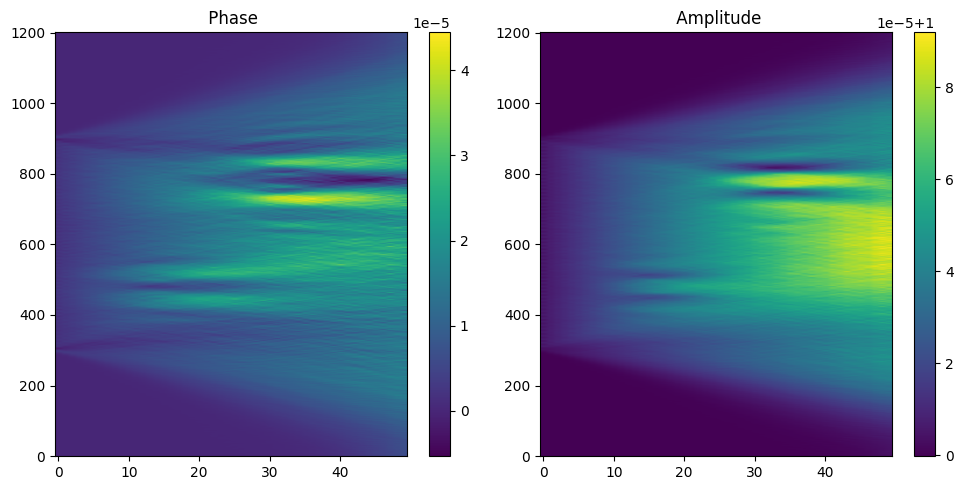

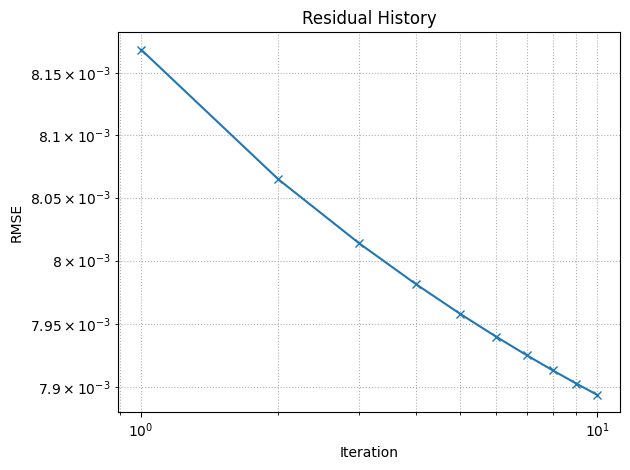

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data.squeeze(), phase_retrieval=True, verbose=True)
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space_pwe, data, phase_retrieval=True, verbose=True)
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=3, tv_lambda_amp=0.6, low_pass_sigma_phase=0.01)
simulation_space_pwe.viewer.plot_two_panels(n_est_pwe, view="phase_amp")
simulation_space_pwe.viewer.plot_residual(residual_pwe)

Initializing Least Squares Solver...
Resetting cache for projection 0, mode forward.
Iteration 1/3
    RMSE: 0.010131394843317806
Resetting cache for projection 0, mode adjoint.
    Iteration 1 took 33.92 seconds.
Resetting cache for projection 0, mode forward.
Iteration 2/3
    RMSE: 0.009828380616554768
Resetting cache for projection 0, mode adjoint.


In [ ]:
print(f"Inf MS Error: {np.max(np.abs(n_est_ms - ptycho_object_ms.n_true))}")
print(f"Inf PWE Error: {np.max(np.abs(n_est_pwe - ptycho_object_pwe.n_true))}")

Inf MS Error: 0.01013635927840845
Inf PWE Error: 0.010176844295572201
